In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

In [2]:
import h5py
Lab1_MNIST = h5py.File('MNISTdata.hdf5','r')
data_in=np.array(Lab1_MNIST['input'])
data_out=np.array(Lab1_MNIST['output'])
print(data_in.shape)
print(data_out.shape)

(2000, 28, 28, 1)
(2000, 1)


In [3]:
train_X,test_X, train_y, test_y = train_test_split(data_in,data_out,test_size=0.3,random_state=21)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1400, 28, 28, 1)
(600, 28, 28, 1)
(1400, 1)
(600, 1)


In [4]:
X_train=train_X.reshape(-1,784)
X_test=test_X.reshape(-1,784)
y_train=train_y.reshape(1400)
y_test=test_y.reshape(600)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1400, 784)
(600, 784)
(1400,)
(600,)


In [5]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1400, 784])
torch.Size([600, 784])
torch.Size([1400])
torch.Size([600])


In [6]:
train_data= list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

In [7]:
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data,batch_size=64, shuffle=False)
for images, labels in trainloader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([64, 784])


In [8]:
# Added one more layer to the model and changed number of units to 400 and 200 respectively
class Model_1(nn.Module):
    def __init__(self,in_features=784,h1 = 400,h2=200, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)          
        self.out = nn.Linear(h2,out_features)
    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.out(x)
        
        return F.log_softmax(x,dim=1)
torch.manual_seed(4)
model_1 = Model_1()
model_1

Model_1(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)

In [9]:
for item in model_1.parameters():
    print(item.numel())

313600
400
80000
200
2000
10


In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=0.05,weight_decay=1e-3)

In [11]:
# Training the model with 100 epochs
import time
start_time = time.time()
epoch=50
trn_loss1=[]
tst_loss1=[]
tst_corr = []
trn_corr = []
for i in range(epoch):
    num_tst_corr = 0
    num_trn_corr = 0
    for b,(X_tr,y_tr) in enumerate(trainloader):
        b+=1
        y_predicted = model_1(X_tr)
        trnl_1=loss(y_predicted,y_tr)
        
        predicted = torch.max(y_predicted.data, 1)[1]    # this calculates the index of maximum value in one hot vector
        batch_corr = (predicted == y_tr).sum()   # this compares target value with model prediction
        num_trn_corr += batch_corr                  # summing up number of correct predictions by the model
        
        optimizer.zero_grad()
        trnl_1.backward()
        optimizer.step()
    
    trn_loss1.append(trnl_1.item())    
    if i%5==0:
        print(f' epoch: {i+1}     train_loss: {trnl_1.item()}')
    
    trn_corr.append(num_trn_corr)
    
    # Cecking the model for the test data (this part is not the par tof backward computation so without gradient)
    with torch.no_grad():
        for c,(X_tst,y_tst) in enumerate(testloader):
            c+=1
            y_val = model_1(X_tst)
            tstl_1=loss(y_val,y_tst)
            
            pred = torch.max(y_val.data, 1)[1]
            batch_corr_test = (pred == y_tst).sum()
            num_tst_corr += batch_corr_test
            
        tst_loss1.append(tstl_1.item())
        if i%5==0:
            print(f' epoch: {i+1}     test_loss: {tstl_1.item()}')
    tst_corr.append(num_tst_corr)
    
end_time = time.time()
total_time = end_time - start_time
print(f'total time: {total_time}')

 epoch: 1     train_loss: 2.3861629962921143
 epoch: 1     test_loss: 2.341542959213257
 epoch: 6     train_loss: 2.797145366668701
 epoch: 6     test_loss: 2.2729132175445557
 epoch: 11     train_loss: 2.299630641937256
 epoch: 11     test_loss: 2.2646169662475586
 epoch: 16     train_loss: 2.5380890369415283
 epoch: 16     test_loss: 2.7029991149902344
 epoch: 21     train_loss: 2.7025036811828613
 epoch: 21     test_loss: 2.975660562515259
 epoch: 26     train_loss: 2.650951623916626
 epoch: 26     test_loss: 2.415436029434204
 epoch: 31     train_loss: 2.3459343910217285
 epoch: 31     test_loss: 2.6055028438568115
 epoch: 36     train_loss: 2.290316343307495
 epoch: 36     test_loss: 2.406499147415161
 epoch: 41     train_loss: 2.610450267791748
 epoch: 41     test_loss: 2.384840250015259
 epoch: 46     train_loss: 2.431135416030884
 epoch: 46     test_loss: 2.5057036876678467
total time: 27.26340103149414


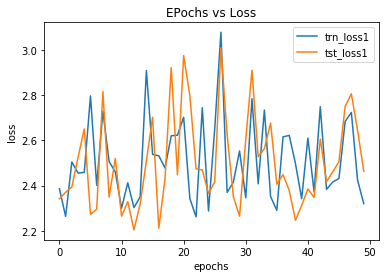

In [12]:
plt.plot(range(epoch),trn_loss1,label='trn_loss1')
plt.plot(range(epoch),tst_loss1,label='tst_loss1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("EPochs vs Loss")
plt.legend()

In [13]:
# Accuracy of 1400 training data over each epoch in percentage
l_trn_accurate=[]
for i in trn_corr:
    l_trn_accurate.append(float(f'{i.item()/14:.2f}'))
print(l_trn_accurate)

[10.57, 11.64, 10.07, 10.29, 12.07, 9.79, 10.14, 10.64, 11.0, 12.14, 11.64, 11.71, 9.79, 11.43, 10.29, 10.93, 13.36, 10.14, 10.93, 12.07, 11.93, 9.21, 10.0, 10.71, 10.36, 9.57, 10.07, 10.86, 12.0, 10.93, 9.93, 10.57, 12.36, 10.71, 12.07, 11.64, 10.71, 12.29, 10.21, 10.86, 11.29, 12.5, 11.5, 10.07, 11.36, 10.86, 12.43, 11.64, 12.5, 14.57]


In [14]:
# Number of correct predictions out of 600 test data over each epoch
l_tst_accurate=[]
for i in tst_corr:
    l_tst_accurate.append(float(f'{i.item()/6:.2f}'))
print(l_tst_accurate)

[10.17, 8.5, 8.5, 8.5, 8.5, 9.17, 14.33, 9.17, 10.17, 10.17, 9.17, 11.33, 10.67, 12.17, 10.17, 11.33, 8.83, 8.83, 11.33, 10.0, 8.5, 9.17, 12.17, 11.33, 12.83, 10.17, 10.17, 24.33, 11.33, 12.0, 18.0, 10.17, 8.5, 20.33, 10.17, 14.5, 8.5, 8.5, 10.17, 11.5, 9.17, 13.33, 8.5, 11.67, 12.17, 11.33, 10.17, 18.5, 11.5, 11.33]


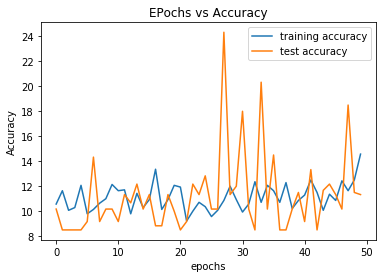

In [15]:
# Comparing the training accuracy and test accuracy
plt.plot(range(epoch),(l_trn_accurate),label='training accuracy')
plt.plot(range(epoch),(l_tst_accurate),label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("EPochs vs Accuracy")
plt.legend()

In [16]:
for i,j in enumerate(range(5)):
    model_1.eval()
    with torch.no_grad():
        new_pred = model_1(test_data[i][0].view(-1,784)).argmax()
        if new_pred != test_data[i][1]:
            print(f"{i+1}.) Predicted value: {new_pred.item()}    Actual label:{test_data[i][1]}     Incorrect prediction")
        else:
            print(f"{i+1}.) Predicted value: {new_pred.item()}    Actual label:{test_data[i][1]}     Correct prediction")

1.) Predicted value: 4    Actual label:4     Correct prediction
2.) Predicted value: 4    Actual label:1     Incorrect prediction
3.) Predicted value: 4    Actual label:3     Incorrect prediction
4.) Predicted value: 4    Actual label:4     Correct prediction
5.) Predicted value: 4    Actual label:6     Incorrect prediction
